# Sales Forecast


We ask you to begin creating a prototype model from the dataset below, which consists of an international online retailer’s transactions from 2010-2011

- To demonstrate your ability to do predictive modeling, demonstrate to us how you would go about forecasting daily sales
    - Given this retailer’s 2010-2011 transactions in the datatest, predict the amount (€) this retailer will sell each day of 2012


#### Library Imports

In [1]:
import os
import logging
import pandas as pd
import itertools
import time
import sys
# import warnings

import statsmodels.api as sm

import matplotlib.pyplot as plt

from statsmodels.tsa.vector_ar.var_model import VAR

# warnings.filterwarnings("ignore")


### Configuration variables

In [2]:
config_dict={
    "log_directory": "/Users/guillem/tmp/",
    "log_level": "DEBUG",
    "base_name": "sales_forecast",
    "input_file_path": "/Users/guillem/Downloads/Online Retail.xlsx",
    "split_date": "2011-11-01"
}

### Procedures

In [4]:
#### INIT LOGGER ################################################################################
def init_logger(log_level, file_location, log_filename):
    """Initializes log structure. """
    logger = logging.getLogger()
    logger.setLevel(log_level)
    timestr = time.strftime("%Y%m%d%H%M%S")
    log_full_path = os.path.normpath(file_location + '/' + timestr + '_'+ log_filename)

    time_format = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    logging.basicConfig(level=log_level,
                        format=time_format,
                        filename=log_full_path,
                        filemode='w')

    ch = logging.StreamHandler(sys.stdout)
    # ch.setLevel('INFO')
    formatter = logging.Formatter(time_format)
    ch.setFormatter(formatter)
    logger.addHandler(ch)

    return logger


#### READ DATA FILE #############################################################
def read_data_file(config_dict, log):
    """Reads process data excel file and returns the corresponding dataframe"""
    file_path = config_dict["input_file_path"]
    log.info('Reading excel file: %s' % file_path)
    file_df = pd.read_excel(file_path, header=0)
    log.debug("data shape: {}".format(file_df.shape))

    # Remove duplicated records
    # Assuming duplicates should not exist
    log.info('Removing duplicates...')
    file_df.drop_duplicates(keep='last', inplace=True)
    log.debug("all data shape: {}".format(file_df.shape))

    # Drop unnamed columns
    log.info('Dropping unnamed columns...')
    drop = []
    for c in file_df.columns:
        if 'unnamed' in c.lower():
            drop.append(c)
    if len(drop) > 0:
        file_df.drop(columns=drop, inplace=True)
        log.debug("all data shape: {}".format(file_df.shape))

    # TODO set types

    return file_df


#### PROCESS DATA #############################################################
def process_data(df, log):
    """Processes raw data into ML ready time series data
       Returns a dataframe indexed by date including daily sales"""
    
    log.info('Cleaning data...')
    
    # 0 unit prices seem to represent thrown units, not sales
    # REMOVE 0 unit prices information
    log.info('Removing non sales data...')
    df = df[(df["UnitPrice"] != 0)].copy()
    log.debug("data shape: {}".format(df.shape))
    
    # a couple rows exist with negative unit prices and description "Adjust bad debt" (to be checked with business)
    # those will be kept as they probably represent valid transactions
    
    # cancellation transactions observed seem to have the same date as their corresponding sale
    # therefore their sum should be neutral in the daily sales aggregation and there's no need to clean manually
    
    log.info('Adding group columns...')
    df['Date'] = pd.to_datetime(df['InvoiceDate']).dt.date
    df['InvoiceAmount'] = (df["UnitPrice"] * df["Quantity"]).round(2)
    log.debug("data shape: {}".format(df.shape))
    
    log.info('Grouping data by daily sales...')
    daily_sales = df.groupby(["Date"]).sum()[["InvoiceAmount"]]
    daily_sales.rename(columns={"InvoiceAmount": "TotalSales"}, inplace=True)
    daily_sales.index = pd.to_datetime(daily_sales.index)
    daily_sales["weekday"] = daily_sales.index.weekday
    daily_sales["monthday"] = daily_sales.index.day
    # month and year are not useful as we only have 1 year data
    # other features such as a holiday could be added
    # data could also be separated by country and by product
    # This way we would train a model for each country/product to obtain more accurate prediction results
    
    full_date_range = pd.date_range(start="2010-12-01", end="2011-12-09", freq="D")
    daily_sales = daily_sales.reindex(full_date_range, fill_value=0)
    # added daily sales maybe could also be interpolated (to be tested)
    
    log.debug("daily sales shape: {}".format(daily_sales.shape))
    
    return daily_sales

### Init Log

In [5]:
# initialize logger
log = init_logger(config_dict["log_level"], config_dict["log_directory"], config_dict["base_name"] + '.log')

### Read data file

In [6]:
df = read_data_file(config_dict, log)
df.shape

2022-11-15 14:56:12,722 - root - INFO - Reading excel file: /Users/guillem/Downloads/Online Retail.xlsx
2022-11-15 14:57:04,525 - root - DEBUG - data shape: (541909, 8)
2022-11-15 14:57:04,526 - root - INFO - Removing duplicates...
2022-11-15 14:57:04,846 - root - DEBUG - all data shape: (536641, 8)
2022-11-15 14:57:04,847 - root - INFO - Dropping unnamed columns...


(536641, 8)

In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [9]:
daily_sales = process_data(df, log)
daily_sales.head()

2022-11-15 14:58:48,578 - root - INFO - Cleaning data...
2022-11-15 14:58:48,580 - root - INFO - Removing non sales data...
2022-11-15 14:58:48,671 - root - DEBUG - data shape: (534131, 8)
2022-11-15 14:58:48,672 - root - INFO - Adding group columns...
2022-11-15 14:58:48,840 - root - DEBUG - data shape: (534131, 10)
2022-11-15 14:58:48,840 - root - INFO - Grouping data by daily sales...
2022-11-15 14:58:48,913 - root - DEBUG - daily sales shape: (374, 3)


,TotalSales,weekday,monthday
2010-12-01,58451.56,2,1
2010-12-02,46088.32,3,2
2010-12-03,45575.38,4,3
2010-12-04,0.00,0,0
2010-12-05,30973.63,6,5


### Data display

2022-11-15 14:58:57,967 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2022-11-15 14:58:57,968 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/Users/guillem/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:57,969 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/Users/guillem/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:57,970 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/Users/guillem/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='no

2022-11-15 14:58:58,011 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/Users/guillem/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-11-15 14:58:58,013 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/Users/guillem/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
2022-11-15 14:58:58,014 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/Users/guillem/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,01

2022-11-15 14:58:58,042 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Phosphate.ttc', name='Phosphate', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,043 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Avenir.ttc', name='Avenir', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,045 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Didot.ttc', name='Didot', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,046 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/SnellRoundhand.ttc', name='Snell Roundhand', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
2022-11

2022-11-15 14:58:58,118 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Marion.ttc', name='Marion', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,119 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMeroitic-Regular.ttf', name='Noto Sans Meroitic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,121 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Arial Narrow Bold Italic.ttf', name='Arial Narrow', style='italic', variant='normal', weight=700, stretch='condensed', size='scalable')) = 11.535
2022-11-15 14:58:58,123 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansKhojki-Regular.ttf', name='Noto Sans Khojki', style='normal', varian

2022-11-15 14:58:58,165 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansTirhuta-Regular.ttf', name='Noto Sans Tirhuta', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,168 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXSizTwoSymBol.otf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-11-15 14:58:58,169 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/KufiStandardGK.ttc', name='KufiStandardGK', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,171 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Times New Roman Italic.ttf', name='Times New Roman', style='italic', va

2022-11-15 14:58:58,224 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Kailasa.ttc', name='Kailasa', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,225 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Arial Narrow.ttf', name='Arial Narrow', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
2022-11-15 14:58:58,229 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Comic Sans MS.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,230 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/SFNSRounded.ttf', name='.SF NS Rounded', style='normal', variant='normal', weight=400, stretch='normal', size='scala

2022-11-15 14:58:58,290 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/AppleSDGothicNeo.ttc', name='Apple SD Gothic Neo', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,294 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansPsalterPahlavi-Regular.ttf', name='Noto Sans Psalter Pahlavi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,296 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXNonUniBolIta.otf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-11-15 14:58:58,297 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Arial Narrow Italic.ttf', name='Arial Narrow', style='italic',

2022-11-15 14:58:58,345 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ角ゴシック W4.ttc', name='Hiragino Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,347 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/PTSans.ttc', name='PT Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,349 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldHungarian-Regular.ttf', name='Noto Sans Old Hungarian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,350 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Verdana Bold.ttf', name='Verdana', style='normal', variant='normal', weight=700, stretch='no

2022-11-15 14:58:58,400 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXSizFourSymBol.otf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-11-15 14:58:58,402 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ角ゴシック W6.ttc', name='Hiragino Sans', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
2022-11-15 14:58:58,403 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Gurmukhi Sangam MN.ttc', name='Gurmukhi Sangam MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,405 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMasaramGondi-Regular.otf', name='Noto Sans Masaram Gondi', style='normal', vari

2022-11-15 14:58:58,444 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Diwan Thuluth.ttf', name='Diwan Thuluth', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,446 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXIntDReg.otf', name='STIXIntegralsD', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,447 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansModi-Regular.ttf', name='Noto Sans Modi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,448 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Apple Braille Outline 8 Dot.ttf', name='Apple Braille', style='normal', variant='normal', weight=4

2022-11-15 14:58:58,486 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Sathu.ttf', name='Sathu', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,488 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansManichaean-Regular.ttf', name='Noto Sans Manichaean', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,489 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Sana.ttc', name='Sana', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,490 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXVar.otf', name='STIXVariants', style='normal', variant='normal', weight=400, stretch='normal', size='s

2022-11-15 14:58:58,529 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Microsoft Sans Serif.ttf', name='Microsoft Sans Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,530 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Gujarati Sangam MN.ttc', name='Gujarati Sangam MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,531 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/PingFang.ttc', name='PingFang HK', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,532 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Al Tarikh.ttc', name='Al Tarikh', style='normal', variant='normal', weight=400, stretch=

2022-11-15 14:58:58,561 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Chalkboard.ttc', name='Chalkboard', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,562 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Courier.ttc', name='Courier', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,563 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansRejang-Regular.ttf', name='Noto Sans Rejang', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,563 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Trebuchet MS Italic.ttf', name='Trebuchet MS', style='italic', variant='normal', weight=400, stretch='normal', 

<AxesSubplot:>

2022-11-15 14:58:58,691 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2022-11-15 14:58:58,693 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/Users/guillem/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,694 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/Users/guillem/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,694 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/Users/guillem/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='no

2022-11-15 14:58:58,715 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/Users/guillem/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-11-15 14:58:58,716 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/Users/guillem/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
2022-11-15 14:58:58,717 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/Users/guillem/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,71

2022-11-15 14:58:58,750 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Phosphate.ttc', name='Phosphate', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,751 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Avenir.ttc', name='Avenir', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,796 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Didot.ttc', name='Didot', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,797 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/SnellRoundhand.ttc', name='Snell Roundhand', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
2022-11

2022-11-15 14:58:58,838 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Marion.ttc', name='Marion', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,839 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMeroitic-Regular.ttf', name='Noto Sans Meroitic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,840 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Arial Narrow Bold Italic.ttf', name='Arial Narrow', style='italic', variant='normal', weight=700, stretch='condensed', size='scalable')) = 11.535
2022-11-15 14:58:58,842 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansKhojki-Regular.ttf', name='Noto Sans Khojki', style='normal', varian

2022-11-15 14:58:58,876 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansTirhuta-Regular.ttf', name='Noto Sans Tirhuta', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,878 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXSizTwoSymBol.otf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-11-15 14:58:58,879 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/KufiStandardGK.ttc', name='KufiStandardGK', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,880 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Times New Roman Italic.ttf', name='Times New Roman', style='italic', va

2022-11-15 14:58:58,917 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Kailasa.ttc', name='Kailasa', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,918 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Arial Narrow.ttf', name='Arial Narrow', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
2022-11-15 14:58:58,919 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Comic Sans MS.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,921 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/SFNSRounded.ttf', name='.SF NS Rounded', style='normal', variant='normal', weight=400, stretch='normal', size='scala

2022-11-15 14:58:58,980 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/AppleSDGothicNeo.ttc', name='Apple SD Gothic Neo', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,983 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansPsalterPahlavi-Regular.ttf', name='Noto Sans Psalter Pahlavi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:58,984 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXNonUniBolIta.otf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-11-15 14:58:58,985 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Arial Narrow Italic.ttf', name='Arial Narrow', style='italic',

2022-11-15 14:58:59,032 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ角ゴシック W4.ttc', name='Hiragino Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:59,034 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/PTSans.ttc', name='PT Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:59,035 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldHungarian-Regular.ttf', name='Noto Sans Old Hungarian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:59,037 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Verdana Bold.ttf', name='Verdana', style='normal', variant='normal', weight=700, stretch='no

2022-11-15 14:58:59,144 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXSizFourSymBol.otf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-11-15 14:58:59,146 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ角ゴシック W6.ttc', name='Hiragino Sans', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
2022-11-15 14:58:59,151 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Gurmukhi Sangam MN.ttc', name='Gurmukhi Sangam MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:59,153 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMasaramGondi-Regular.otf', name='Noto Sans Masaram Gondi', style='normal', vari

2022-11-15 14:58:59,251 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Diwan Thuluth.ttf', name='Diwan Thuluth', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:59,252 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXIntDReg.otf', name='STIXIntegralsD', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:59,253 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansModi-Regular.ttf', name='Noto Sans Modi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:59,255 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Apple Braille Outline 8 Dot.ttf', name='Apple Braille', style='normal', variant='normal', weight=4

2022-11-15 14:58:59,371 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Sathu.ttf', name='Sathu', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:59,372 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansManichaean-Regular.ttf', name='Noto Sans Manichaean', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:59,373 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Sana.ttc', name='Sana', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:59,374 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXVar.otf', name='STIXVariants', style='normal', variant='normal', weight=400, stretch='normal', size='s

2022-11-15 14:58:59,415 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Microsoft Sans Serif.ttf', name='Microsoft Sans Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:59,416 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Gujarati Sangam MN.ttc', name='Gujarati Sangam MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:59,417 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/PingFang.ttc', name='PingFang HK', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:59,419 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Al Tarikh.ttc', name='Al Tarikh', style='normal', variant='normal', weight=400, stretch=

2022-11-15 14:58:59,549 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Chalkboard.ttc', name='Chalkboard', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:59,553 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Courier.ttc', name='Courier', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:59,558 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansRejang-Regular.ttf', name='Noto Sans Rejang', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-15 14:58:59,565 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Trebuchet MS Italic.ttf', name='Trebuchet MS', style='italic', variant='normal', weight=400, stretch='normal', 

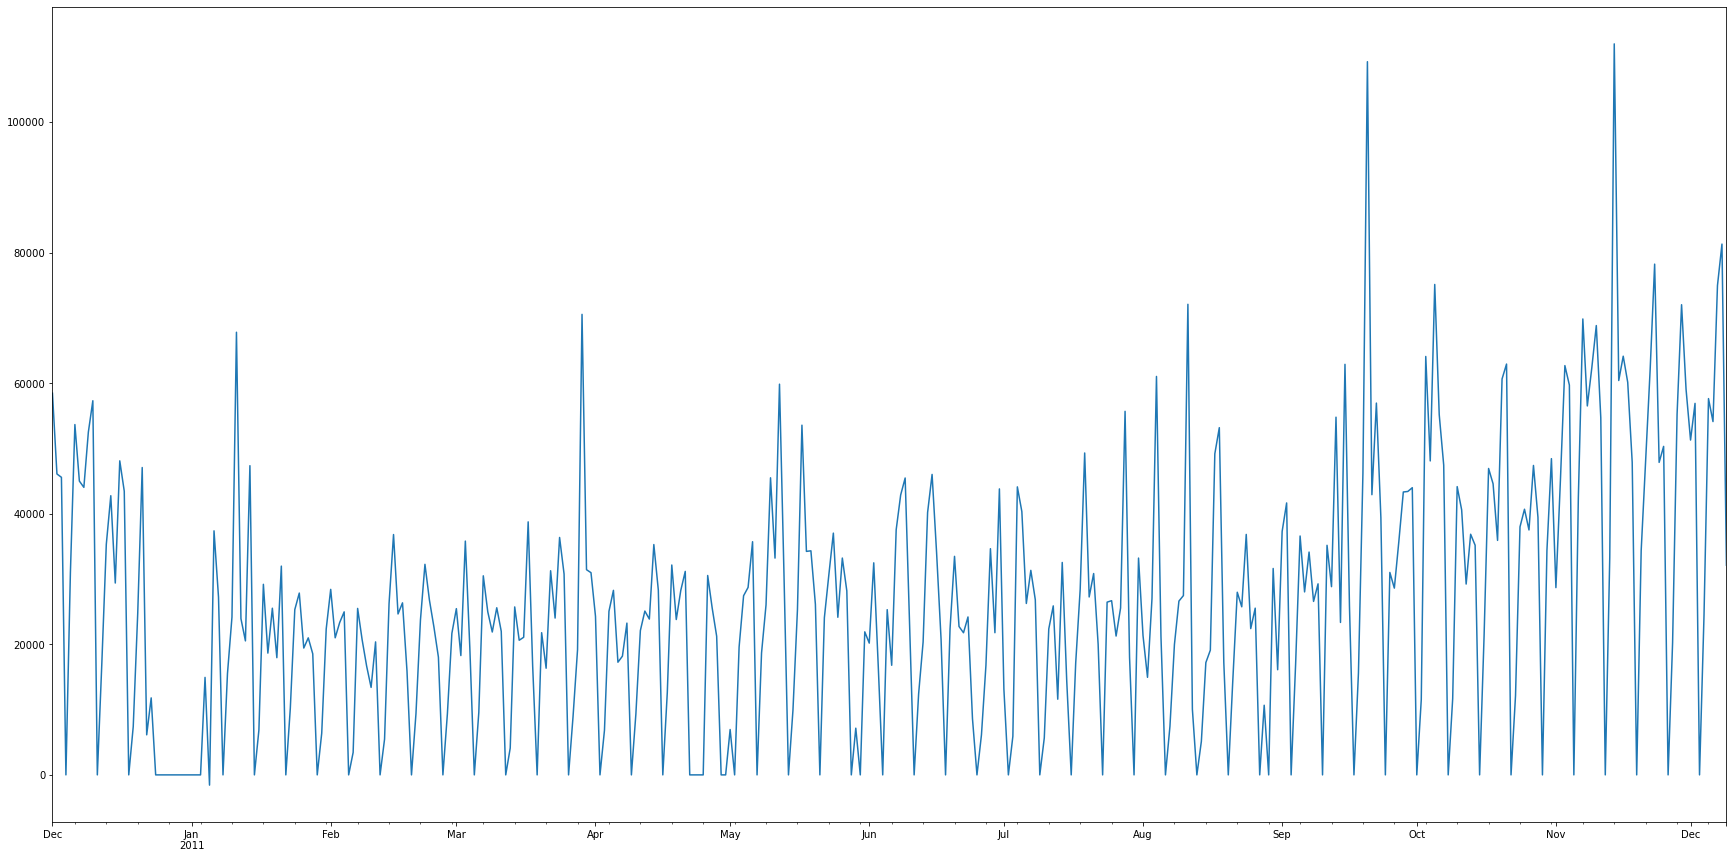

In [10]:
plt.rcParams["figure.figsize"] = (30,15)
daily_sales["TotalSales"].plot()

### Prepare ML datasets

In [12]:
Y = daily_sales[["TotalSales"]].asfreq('D')

### Time Series decomposition

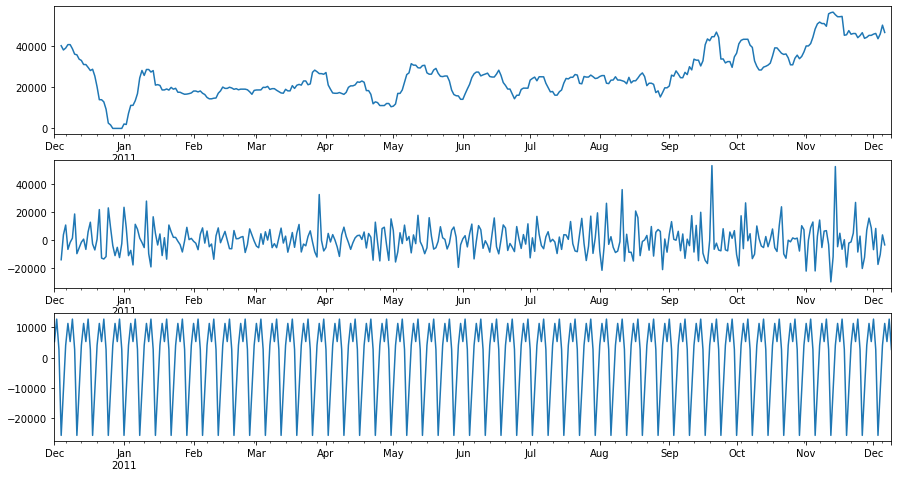

In [13]:
decomposition = sm.tsa.seasonal_decompose(Y, model='additive')
#fig = decomposition.plot()
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
decomposition.trend.plot(ax=ax1)
decomposition.resid.plot(ax=ax2)
decomposition.seasonal.plot(ax=ax3)
plt.rcParams["figure.figsize"] = (30,30)
plt.rcParams["xtick.labelsize"] = 20
plt.show()

From the above graph sales appear to be instable and have a strong seasonability which seems to be weekly. We will end up using seasonality of 28 as it provides better AIC results than other ones tested (7, 12 and 14). (See AIC tests below)

We are going to test modeling with SARIMAX by using all possible parameters combinations

### Prepare SARIMA parameter combinations

Seasonality, trend and noise combinations should be tested.

In [30]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 28) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 28)
SARIMAX: (0, 0, 1) x (0, 1, 0, 28)
SARIMAX: (0, 1, 0) x (0, 1, 1, 28)
SARIMAX: (0, 1, 0) x (1, 0, 0, 28)


In [23]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [31]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(Y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(disp=0)
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 28) - AIC:8815.145215585146
ARIMA(0, 0, 0)x(0, 0, 1, 28) - AIC:8030.697611251104
ARIMA(0, 0, 0)x(0, 1, 0, 28) - AIC:7716.340362949217
ARIMA(0, 0, 0)x(0, 1, 1, 28) - AIC:6982.443889386853
ARIMA(0, 0, 0)x(1, 0, 0, 28) - AIC:7742.352018128246
ARIMA(0, 0, 0)x(1, 0, 1, 28) - AIC:7571.525459635161
ARIMA(0, 0, 0)x(1, 1, 0, 28) - AIC:7006.566024215568
ARIMA(0, 0, 0)x(1, 1, 1, 28) - AIC:6978.64274777261
ARIMA(0, 0, 1)x(0, 0, 0, 28) - AIC:8599.616774602773
ARIMA(0, 0, 1)x(0, 0, 1, 28) - AIC:7821.084828779128
ARIMA(0, 0, 1)x(0, 1, 0, 28) - AIC:7670.5134382622
ARIMA(0, 0, 1)x(0, 1, 1, 28) - AIC:6956.297409382695
ARIMA(0, 0, 1)x(1, 0, 0, 28) - AIC:7879.784844919972
ARIMA(0, 0, 1)x(1, 0, 1, 28) - AIC:7802.4551451955085
ARIMA(0, 0, 1)x(1, 1, 0, 28) - AIC:7010.43807496654
ARIMA(0, 0, 1)x(1, 1, 1, 28) - AIC:6956.539208750804
ARIMA(0, 1, 0)x(0, 0, 0, 28) - AIC:8477.404403493383
ARIMA(0, 1, 0)x(0, 0, 1, 28) - AIC:7790.919069048934
ARIMA(0, 1, 0)x(0, 1, 0, 28) - AIC:7823.462832823

The best resulting execution is the following:

ARIMA(1, 1, 1)x(0, 1, 1, 28) - AIC:6912.377157153407

### Fit model (with all data) and view results

In [38]:
mod = sm.tsa.statespace.SARIMAX(Y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 28))
results = mod.fit(disp=0)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         TotalSales   No. Observations:                  374
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 28)   Log Likelihood               -3788.615
Date:                            Tue, 15 Nov 2022   AIC                           7585.231
Time:                                    17:38:43   BIC                           7600.605
Sample:                                12-01-2010   HQIC                          7591.353
                                     - 12-09-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0724      0.111      0.652      0.515      -0.145       0.290
ma.L1         -0.8368      0.057   

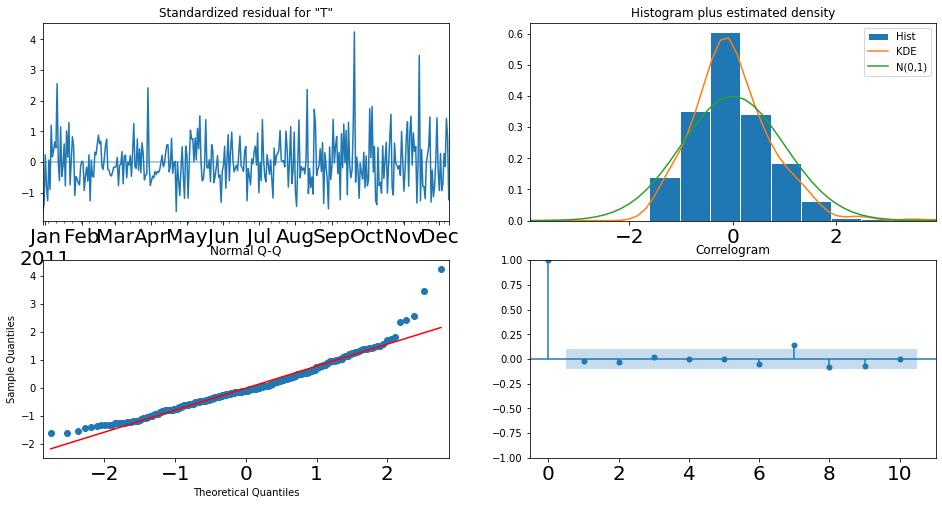

In [33]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

**Standard residual** show no pattern or correlation which is good.

**Histogram** distribution is far from perfect (green line) but almost looks Gaussian

**Quantiles correlation** looks quite constant except for high values

**Correlogram** shows how 7th coefficient has more meaning that could make sense with the weekly patterns

### Print forecast results:

In [34]:
pred = results.get_prediction(start=pd.to_datetime('2011-08-01'), dynamic=False)
pred_conf_interval = pred.conf_int()

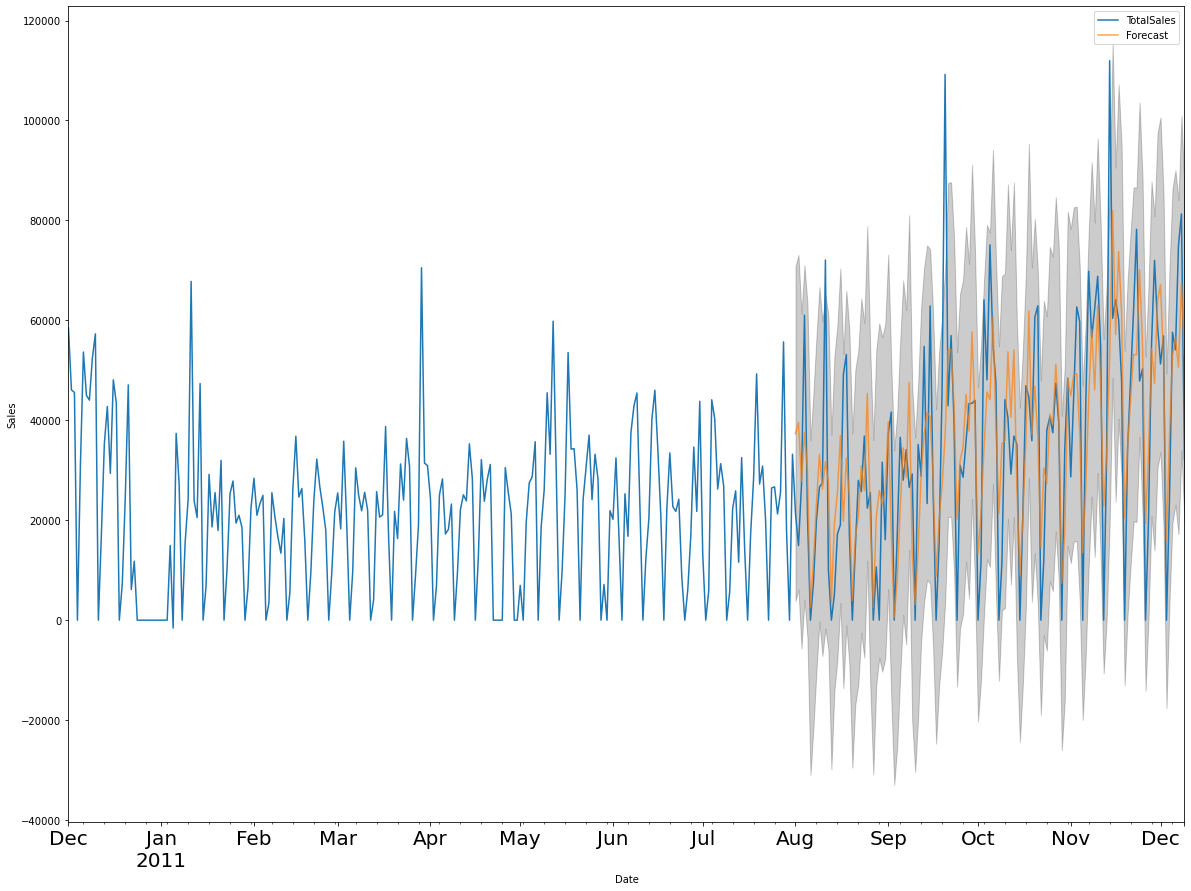

In [36]:
ax = Y['2010-12-01':].plot()
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(20, 15))
ax.fill_between(pred_conf_interval.index,
                pred_conf_interval.iloc[:, 0],
                pred_conf_interval.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()